In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize
from pymoo.termination import get_termination

from moo.problems.enroads_problem import EnroadsProblem
from enroadspy import load_input_specs

In [77]:
gdp_actions = ["_long_term_gdp_per_capita_rate", "_near_term_gdp_per_capita_rate", "_transition_time_to_reach_long_term_gdp_per_capita_rate"]
gdp_outcomes = [f"GDP MSE {i}" for i in range(1, 6)]

In [78]:
# Hyperparams from pymoo docs:
# pop size 10xnvar, F=0.8, CR=0.9
algorithm = DE(
    pop_size=30,
    F=0.8,
    CR=0.9
)

In [79]:
rows = []
for outcome in gdp_outcomes:
    problem = EnroadsProblem(gdp_actions, {outcome: True})
    res = minimize(problem, algorithm, seed=1, verbose=False)
    print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))
    row = dict(zip(gdp_actions, res.X))
    row["F"] = res.F[0]
    row["scenario"] = outcome
    rows.append(row)

df = pd.DataFrame(rows)
df.to_csv("experiments/scenarios/gdp_context.csv", index=False)

make: `enroads' is up to date.
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       30 |  1.915823E+10 |  2.944098E+08
     2 |       60 |  5.124908E+09 |  1.689328E+08
     3 |       90 |  1.978851E+09 |  1.689328E+08
     4 |      120 |  1.077990E+09 |  1.689328E+08
     5 |      150 |  6.664670E+08 |  1.302658E+08
     6 |      180 |  4.718920E+08 |  8.672578E+07
     7 |      210 |  3.843024E+08 |  8.672578E+07
     8 |      240 |  3.246316E+08 |  7.178267E+07
     9 |      270 |  2.395334E+08 |  6.430761E+07
    10 |      300 |  1.909599E+08 |  4.502346E+07
    11 |      330 |  1.545901E+08 |  4.320276E+07
    12 |      360 |  1.293743E+08 |  4.320276E+07
    13 |      390 |  1.121969E+08 |  3.956376E+07
    14 |      420 |  1.064693E+08 |  3.956376E+07
    15 |      450 |  1.016499E+08 |  3.956376E+07
    16 |      480 |  9.890346E+07 |  3.956376E+07
    17 |      510 |  8.341276E+07 |  3.956376E+07
    18 |      540 |  6.886153E+07 |  3.956376E+07
    19 |      570 |

In [ ]:
year_cols = [2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
year_cols_str = [str(year) for year in year_cols]
year_idxs = [year - 1990 for year in year_cols]

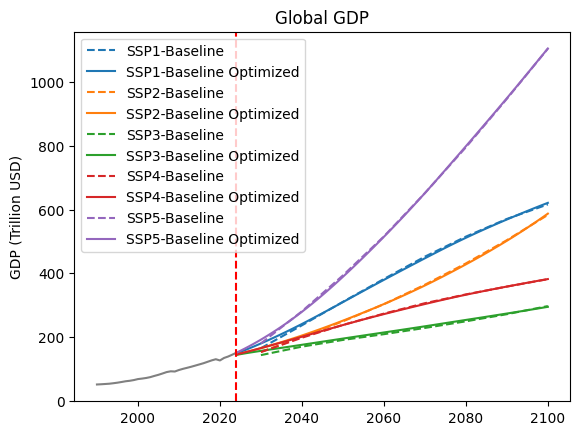

In [93]:
label_df = pd.read_csv("experiments/scenarios/ar6_snapshot_1723566520.csv/ar6_snapshot_1723566520.csv")
label_df = label_df.dropna(subset=["Scenario"])
label_df = label_df.dropna(axis=1)
label_gdp = label_df[label_df["Variable"] == "GDP|PPP"]

results_df = pd.read_csv("experiments/scenarios/gdp_context.csv")

# Default matplotlib colors in hexcode
matplotlib_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
]
for i, row in results_df.iterrows():
    scenario = row["scenario"]
    actions_dict = row[gdp_actions].to_dict()
    outcomes_df = problem.runner.evaluate_actions(actions_dict)
    optim_gdp = outcomes_df["Global GDP"]

    label_scenario = label_gdp[label_gdp["Scenario"] == scenario]
    label_gdp_vals = label_scenario[year_cols_str].values[0] / 1000

    plt.plot(year_cols, label_gdp_vals, label=scenario, color=matplotlib_colors[i], linestyle="--")
    plt.plot(range(2024, 2101), optim_gdp[2024-1990:], label=f"{scenario} Optimized", color=matplotlib_colors[i])

plt.plot(range(1990, 2025), optim_gdp[:2025-1990], color="gray")
plt.axvline(2024, color="red", linestyle="--")
plt.legend()
plt.title("Global GDP")
plt.ylabel("GDP (Trillion USD)")
plt.show()

In [111]:
# Attach populations to the contexts
label_pop = label_df[label_df["Variable"] == "Population"]

input_specs = load_input_specs()
pop_row = input_specs[input_specs["varId"] == "_global_population_in_2100"]
pop_min = pop_row["minValue"].iloc[0]
pop_max = pop_row["maxValue"].iloc[0]

pops = []
for i, row in results_df.iterrows():
    scenario = row["scenario"]
    label = label_pop[label_pop["Scenario"] == scenario]["2100"].values[0] / 1000
    pop = max(min(label, pop_max), pop_min)
    pops.append(pop)

results_df["_global_population_in_2100"] = pops
results_df.to_csv("experiments/scenarios/gdp_context.csv", index=False)